# 🧬 **AI for Biology** 🧬

<a href="https://ibb.co/Cs0GsQD"><img src="https://i.ibb.co/mFzWF4g/d3ccc3f8-69e2-428f-8ec4-896221936735.webp" alt="Scifi collage of AI in biology" border="0"></a>

<a href="https://colab.research.google.com/github/deep-learning-indaba/indaba-pracs-2024/blob/main/practicals/ML_for_Bio_Indaba_Practical_2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

© Deep Learning Indaba 2024. Apache License 2.0.

**Authors:** Natasha Latysheva

**Topics:** Biology, DNA, Large Language Models, Embeddings, Supervised and Self-Supervised Learning.

**Level**: Beginner

**Aims/Learning Objectives:** Understand DNA embeddings and fine-tune a DNA language model

# AI for Biology
Welcome to the **AI for Biology** practical! In this session, we will:
- Learn about some of major application areas of AI in the biosciences
- Go over the role of DNA and how DNA language models are trained
- Extract and explore DNA embeddings using a pre-trained state-of-the-art DNA language model
- Dive in to a hands-on problem on modelling DNA sequences and their properties

**Prerequisites:**

1. Basic Python
2. No Bio required

**Practical Outline:**

<div align="left">
<a href="https://ibb.co/jryGWdL"><img src="https://i.ibb.co/kS409ph/Screenshot-2024-07-23-at-21-48-22.png" alt="Screenshot-2024-07-23-at-21-48-22" width="400" border="0"></a>
</div>



**Before you start:**

For this practical, you will need to use a GPU to speed up training. To do this, go to the "Runtime" menu in Colab, select "Change runtime type" and then in the popup menu, choose "GPU" in the "Hardware accelerator" box.


We can also already install and import all of the required packages:

In [ ]:
## Install and import anything required, download models, download data.
# @title Install and import required packages. (Run Cell)
%%capture

# Installations.
!pip install transformers datasets
!pip install biopython requests h5py
!pip install umap-learn

# Imports.
import os
import random
import tqdm

import jax
import jax.numpy as jnp
from jax import grad, jit, vmap
import flax.linen as nn
import optax
import torch

import numpy as np
import pandas as pd
import h5py

import matplotlib.pyplot as plt
import seaborn as sns

from Bio import Entrez, SeqIO

from sklearn.manifold import TSNE
from umap import UMAP

from google.colab import drive

from transformers import AutoTokenizer, AutoModelForMaskedLM

# Download DNA language model and tokenizer.
tokenizer = AutoTokenizer.from_pretrained(
    "InstaDeepAI/nucleotide-transformer-v2-50m-multi-species",
    trust_remote_code=True)

language_model = AutoModelForMaskedLM.from_pretrained(
    "InstaDeepAI/nucleotide-transformer-v2-50m-multi-species",
    trust_remote_code=True)

# Download pre-extracted embeddings for random DNA strings.
dna_sequences = pd.read_csv(os.path.join(ROOT_DIR, 'dna_sequences.csv'))

# Download pre-extracted embeddings for fine-tuning our later model.
drive.mount('/content/drive')
ROOT_DIR = '/content/drive/MyDrive/Book/DNA/'
train_df = pd.read_csv(os.path.join(ROOT_DIR, 'train_embeddings.csv'))
valid_df = pd.read_csv(os.path.join(ROOT_DIR, 'valid_embeddings.csv'))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# @title Check TPU/GPU. (Run Cell)
num_devices = jax.device_count()
device_type = jax.devices()[0].device_kind

print(f"Found {num_devices} JAX devices of type {device_type}.")

Found 1 JAX devices of type NVIDIA A100-SXM4-40GB.



## 1. Applications of AI in Biology

AI is becoming increasingly common in the biological domain, and has seen some really exciting recent advances. However, the field is still in its early days – this means there is lots of interesting work that remains to be done and it’s an excellent time to get involved!

Here is a quick survey of some exciting AI in biology work across a few different areas.


### Medical Diagnostics

Skin cancer classification models such as [this one from MIT](https://www.science.org/doi/10.1126/scitranslmed.abb3652) achieve comparable performance to certified dermatologists:
<div align="center">
    <img src="https://wp.technologyreview.com/wp-content/uploads/2021/06/automated-melanoma-detection-small2.gif?w=400" alt="Automated Melanoma Detection GIF">
</div>


A retinal disease segmentation and classification [model from DeepMind](https://www.nature.com/articles/s41591-018-0107-6) is capable of diagnosing many ophthalmic conditions from 3D retinal scans. Its performance is similar to the best retinal specialists and outperforms some human experts:



<div align="center">
    <img src="https://miro.medium.com/v2/resize:fit:1400/format:webp/1*cnyoA2T8BFZRBYWnUlYEtQ.gif" alt="Retinal scan segmentation gif">
</div>

[The SynthSR model from Harvard and UCL]() can take clinical brain MRI scans with any contrast, orientation and resolution and turn them into high-resolution 3D images:

<div align="center">
    <img src="https://www.science.org/cms/10.1126/sciadv.add3607/asset/7a6c5ed9-af95-41d2-b888-2b5a653ea55b/assets/images/large/sciadv.add3607-f1.jpg" alt="SynthSR MRI scan model" width="400">
</div>



### Pharma and Drug Development

[Exscientia](https://www.exscientia.com/) developed the first AI-designed drug to enter clinical trials (DSP-1181, aimed at treating obsessive-compulsive disorder).

Many AI-assisted drug discovery efforts use models to predict how tightly small molecules will bind to different regions of a target protein involved in a given disease:

<div align="center">
    <img src="https://developer-blogs.nvidia.com/wp-content/uploads/2023/03/bionemo_featured.jpeg" alt="general pocket showing" width="400">
</div>


[BenevolentAI](https://www.benevolent.com/about-us/sustainability/covid-19/) used AI to identify Baricitinib, originally an arthritis drug, as a potential treatment for COVID-19 within 48 hours by using their knowledge graph.


<div align="center">
    <img src="https://www.benevolent.com/application/files/6616/7458/5885/Corona_Baricitinib.png" alt="BenevolentAI Baricitinib" width="400">
</div>

[Link to YouTube video titled "BenevolentAI · AI-Enabled Drug Discovery"](https://www.youtube.com/watch?v=RPBDhogTIT0)

[Recursion Pharmaceuticals](https://www.recursion.com/) is famous for high-throughput screening and optimization, and has built advanced cell imaging models:

<div align="center">
    <img src="https://miro.medium.com/v2/resize:fit:1400/0*yVLwEtfojWdnMZfA" alt="Recursion" width="800">
</div>


They train models to predict missing pixels in cell images in a similar way that large language models predict missing or masked words in sentences:

<div align="center">
    <img src="https://blogs.nvidia.com/wp-content/uploads/2024/05/Recursion-Phenom-AI-model-animation.gif" alt="Recursion" width="800">
</div>

Other startups doing deep learning for drug discovery include Atomwise, insitro, Insilico Medicine, Deep Genomics, and Deepcell.

Also, large pharma companies like Illumina, GSK, and Genentech have established internal deep learning teams and developed influential models such as [SpliceAI](https://www.cell.com/cell/pdf/S0092-8674(18)31629-5.pdf) (a model that understands splicing) and [PrimateAI](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6237276/) (a model that predicts the clinical effect of mutations in proteins), showcasing the increasing integration of deep learning in biology workflows.




### Molecular biology

The [AlphaFold model by DeepMind](https://www.nature.com/articles/s41586-021-03819-2) has revolutionized the field of protein structure prediction, gaining widespread adoption and recognition across academia, biotech, and pharmaceutical industries:

<div align="center">
    <img src="https://spectrum.ieee.org/media-library/two-examples-of-protein-targets-in-the-free-modelling-category-in-green-is-the-experimental-result-in-blue-is-the-computationa.gif?id=25559695&width=2400&height=1358" alt="AlphaFold predictions" width="800">
</div>


Researchers from [EvolutionaryScale](https://www.evolutionaryscale.ai/blog/esm3-release) used their ESM3 protein language model to design a new fluorescent protein that is quite distinct compared to fluorescent proteins found in nature:

<div align="center">
    <img src="https://cdn.prod.website-files.com/6606dc3fd5f6645318003e20/667a5bb780d0ada7dc37d1c0_image%20(1).png" alt="ESM3" width="400">
</div>




### Ecology and Conservation

[Rainforest Connection (RFCx)](https://rfcx.org/) is an innovative project that places modified smartphones in trees, records audio, and then uses models to identify different species present in the area. This helps monitor biodiversity and detect illegal activities like logging in real-time.

<div align="center">
    <img src="https://www.huawei.com/~/media/CORPORATE/Images/case-studies/case1/photo-grid.jpg" alt="Rainforest connection setup" width="600">
</div>

<div align="center">
    <img src="https://cdn.ttgtmedia.com/visuals/LeMagIT/Forest1.png" alt="Rainforest connection audio" width="600">
</div>



[Project CETI](https://www.projectceti.org/) (Cetacean Translation Initiative) uses AI to analyse and decode whale sounds to understand their communication and behavior.


<div align="center">
    <img src="https://i0.wp.com/www.josephdelpreto.com/wp-content/uploads/2023/09/Project-CETI_s-Approach-_-Illustration-%C2%A9-2023-Alex-Boersma.jpg?resize=1024%2C912" alt="CETI whale" width="600">
</div>


A Zindi competition called [Turtle Recall](https://zindi.africa/competitions/turtle-recall-conservation-challenge) challenged users to build a model that could identify individual sea turtles from the scale patterns on their heads, which could help improve sea turtle conversation efforts:

<div align="center">
    <img src="https://lh3.googleusercontent.com/9J6DZgiuGyYr3N1DoJBmZMVpBkTlGOq19QUws7G2fbFcuHeIJKQ3plFh-R2xkxB1OpVaqZhcglM6hWWl5x7PuuxbtnDlIWlCgoCr0LGVM4S-loaj_Jc=w1232-rw" alt="Turtle recall" width="600">
</div>



**Poll**: Show of hands, which of these subfields of AI for biology do you find most interesting?
1. 🏥 **Medical Diagnostics** 🏥
2. 💊 **Pharma and Drug Development** 💊
3. 🧬 **Molecular Biology** 🧬
4. 🌳 **Ecology and Conservation** 🌳
5. **Other** (which? :)

**Question**: what other interesting work in the space of AI in biology do you know about?

### Additional background reading

These examples are not exhaustive and are merely there to give you a taste for some current applications of AI in biology. If you'd like to learn more about this space, here are some interesting resources to read:

- *Nature Communications* 2022 review titled ["Current progress and open challenges for applying deep learning across the biosciences"](https://www.nature.com/articles/s41467-022-29268-7)
- Slightly older (2018) review paper titled [“Opportunities and obstacles for deep learning in biology and medicine”](https://royalsocietypublishing.org/doi/10.1098/rsif.2017.0387). This has reached over 2,000 citations!
- ["Deep Learning for the Life Sciences"](https://www.oreilly.com/library/view/deep-learning-for/9781492039822/) 2019 O'Reilly book,which provides practical insights and applications of deep learning in genomics, chemistry, and bioinformatics.









## 2. Introduction to DNA


We hope that introduction was enough to get you excited about deep learning applications in biology! For the rest of this practical session, let's do some of the AI in bio work ourselves, on the topic of **DNA**.

<div align="center">
    <img src="https://i.pinimg.com/originals/c7/90/76/c79076215950e968828f663e1b69fe67.gif" alt="DNA gif" width="200">
</div>


**DNA is the molecule of inheritance, the basis of all life as we know it**.

Its structure was first discovered in 1953, marking a pivotal moment in biological sciences. The first draft of the human genome was published in 2001, laying the groundwork for modern genomics.

But these dates are quite recent, and although we now know some of the "what" of the genome, we are very far from knowing the "how" of how it actually functions.

For example, we know that DNA is composed of 4 different "letters", namely "A", "C", "G", and "T", and that the human genome is composed of 3.2 billion letters that are spread across 23 pairs of chromosomes. The DNA is packed down in various ways in order to fit into the cell nucleus:

<div align="center">
    <img src="https://miro.medium.com/v2/resize:fit:1400/1*EUKrGpPzUAwp2sOOPZOcqA.jpeg" alt="DNA text" width="400">
</div>

If we were to open the "book" of the human genome, we would see something like this:

<div align="center">
    <img src="https://cms.wellcome.org/sites/default/files/styles/image_full_hi/public/WI_C0035768_GenomeEditing_20150902_News_600x600.jpg?itok=FCedpedU" alt="DNA text" width="400">
</div>

**This can be very hard to interpret**. And there is a lot of DNA to interpret – enough to fill a bookcase if printed across book volumes:

<div align="center">
    <img src="https://live.staticflickr.com/3265/2569126918_b68047a65b_b.jpg" alt="DNA bookcase" width="400">
</div>


Some of the main open questions we have about DNA are:
- What do the 3.2 billion letters of the human genome do? Are all of them biologically functional?
- How can each cell in the human body have exactly the same genome, but have vastly different functions? For example, think of how different a neuron is from a muscle cell.
- We know that only approximately 2% of the DNA in the genome codes for proteins, what does the remaining 98% do?
- How does genetic variation lead to disease or to the differences we observe between individuals?

To summarise:

***The human genome can be seen as a very long book with its words composed of the letters A, T, C and G. Deep learning models hold great promise for understanding the genome due to their ability to capture signal in large, complex and potentially noisy data.***

## DNA Language Models

**DNA language models (LMs)** are very similar to large language models you might be familiar with such as ChatGPT, Gemini, Claude, etc. Instead of being trained on large amounts of natural language text, DNA LMs are trained on large amounts of DNA sequences.

Both many LLMs and DNA LMs are trained by randomly **masking** some tokens in the text, and then having the model predict what the token is:

<div align="center">
<a href="https://ibb.co/M9d9GM0"><img src="https://i.ibb.co/25J5sg4/Screenshot-2024-07-23-at-22-18-57.png" alt="Screenshot-2024-07-23-at-22-18-57" width="800" border="0"></a>
</div>

In the same way that LLMs learn insight into language that can then be useful for many downstream tasks,
DNA language models can capture the complex patterns and structures within DNA, making them valuable for various downstream genomic tasks such as mutation analysis and understanding regulatory elements:

## Some popular DNA language models

As LLMs have become massively successful, more and more people have become interested in training DNA language models. Some of the most famous ones are:

- [DNABERT](https://academic.oup.com/bioinformatics/article/37/15/2112/6128680) (2021) - DNABERT adapts the BERT model, which has been highly successful in NLP, to understand DNA sequences.
- [HyenaDNA](https://arxiv.org/abs/2306.15794) (2023) - Specialises in long DNA sequences, with context lengths of up to 1 million tokens at the single nucleotide-level.
- [Nucleotide Transformer](https://www.biorxiv.org/content/10.1101/2023.01.11.523679v1) (2023) - a transformer-based architecture specifically designed for nucleotide sequences.

Some people have also fine-tuned existing natural language LLMs on DNA sequences, for example [Mistral-DNA](https://github.com/raphaelmourad/Mistral-DNA).

For this practical, we will be using the Nucleotide Transformer
(NT) model because it is quite good, popular, and readily available on the [Hugging Face platform 🤗](https://huggingface.co/).



## The Nucleotide Transformer (NT) model

Nucleotide Transformer was trained on 3,202 diverse human genomes, as well as 850 genomes from a wide range of species.The model generates transferable, context-specific representations of DNA sequences.

Some more details on the model:
- NT is an encoder-only transformer architecture, trained using the BERT approach (masking parts of DNA sequences). The DNA sequences were tokenised to 6-mers.
- It is an unsupervised model, but its representations alone match or outperform specialized methods on 11 of 18 prediction tasks, such as predicting whether a given piece of DNA contains certain regulatory elements known as promoters and enhancers.
- The training data for the `nucleotide-transformer-v2-50m-multi-species` version of NT was trained on a total of **174B nucleotides**, i.e roughly **29B tokens**. Here are the stats per organism group:

| Class                | Number of species  | Number of nucleotides (B) |
| ---------------------| -------------------| --------------------------|
| Bacteria             | 667                | 17.1                      |
| Fungi                | 46                 | 2.3                       |
| Invertebrate         | 39                 | 20.8                      |
| Protozoa             | 10                 | 0.5                       |
| Mammalian Vertebrate | 31                 | 69.8                      |
| Other Vertebrate     | 57                 | 63.4                      |

There are other, larger versions of the model on Hugging Face available [here](https://huggingface.co/collections/InstaDeepAI/nucleotide-transformer-65099cdde13ff96230f2e592). We are using a relatively small model here for speed reasons.

## Exploring DNA embeddings across different species

Let's load up the Nucleotide Transformer (NT) model from HuggingFace and start playing around with it!

We already loaded up the tokenizer and model in the first cell of the notebook. They are these two objects:

In [ ]:
type(tokenizer)

transformers.models.esm.tokenization_esm.EsmTokenizer

In [ ]:
type(language_model)

transformers_modules.InstaDeepAI.nucleotide-transformer-v2-50m-multi-species.ebe8e9ea00908a1e5a8f289d47d95bb09aac9f19.modeling_esm.EsmForMaskedLM


Let's see what the model has learned about DNA across different species. We can grab random DNA sequences from different species, use the model to extract an **embedding** representation of the DNA, and see if similar species tend to have DNA with similar representations.

Let's come up with a list of species of interest:

In [ ]:
organisms = [
    'Homo sapiens',  # Human
    'Pan troglodytes',  # Chimpanzee
    'Pan paniscus',     # Bonobo
    'Gorilla gorilla',  # Gorilla
    'Tursiops truncatus',  # Dolphin (bottlenose)
    'Hydrochoerus hydrochaeris',  # Capybara
    'Escherichia coli',  # E. coli bacteria
    'Lactobacillus acidophilus',  # Common probiotic bacterium
    'Salmonella enterica',  # Common foodborne pathogen
    'Pseudomonas aeruginosa',  # Bacterium found in soil and water
]

print(len(organisms))

10


We can use the `Entrez` Python library to do a database search for a random DNA string for a given organism:

In [ ]:
organism = 'Homo sapiens'

Entrez.email = "your.email@example.com"  # Required. Can be a placeholder.

# Search for DNA records for the organism.
handle = Entrez.esearch(
      db='nucleotide', term=f'{organism}[Organism]', retmax=10)
record = Entrez.read(handle)
handle.close()

# Grab a random record.
np.random.seed(42)
random_record_id = random.choice(record['IdList'])

# Read the DNA.
handle = Entrez.efetch(
    db='nucleotide', id=random_record_id, rettype='fasta', retmode='text')
seq_record = SeqIO.read(handle, 'fasta')

print(seq_record)

ID: pdb|8W0A|D
Name: pdb|8W0A|D
Description: pdb|8W0A|D Chain D, DNA (5'-D(P*TP*TP*TP*TP*TP*TP*T)-3')
Number of features: 0
Seq('CCAACCGACCACACCCACCACCCTACCGCCTTTTTTTTTTTTTTT')


We can easily grab the DNA string from this entry:

In [ ]:
dna_sequence = str(seq_record.seq)
dna_sequence

'CCAACCGACCACACCCACCACCCTACCGCCTTTTTTTTTTTTTTT'

The NT model can be used to compute a numerical representation of the meaning of this DNA string. We will simply pass the DNA string as input, tokenize it, and extract the final hidden layer activations from the model:

In [ ]:
# Tokenize the DNA sequence.
max_length = tokenizer.model_max_length

token_ids = tokenizer.batch_encode_plus(
  [dna_sequence], return_tensors='pt',
  padding='max_length', max_length=max_length)['input_ids']

token_ids

tensor([[   3, 2576, 3240,  ...,    1,    1,    1]])

You can see that the DNA sequence has been tokenised, and padded with the `1` token up to the max length of 2048:

In [ ]:
len(token_ids[0])

2048

In [ ]:
token_ids[0][-50:]  # Show the last 50 tokens.

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1])

Now let's grab the model output given this DNA input:

In [ ]:
attention_mask = token_ids != tokenizer.pad_token_id

torch_outs = language_model(
  token_ids,
  attention_mask=attention_mask,
  encoder_attention_mask=attention_mask,
  output_hidden_states=True,
)

We can see that 13 different hidden state outputs are present, representing outputs from 13 different layers in the model:

In [ ]:
len(torch_outs['hidden_states'])

13

Let's grab the final hidden state at index `-1` since this is likely to be informative (but perhaps not optimally informative for every task - we could try the second to last hidden state, or the third to last, etc.):

In [ ]:
embeddings = torch_outs['hidden_states'][-1].detach()
embeddings = np.squeeze(embeddings.numpy())
embeddings.shape

(2048, 512)

We can see that the embedding is a matrix of shape 2048 by 512. That's a big numpy matrix!

In [ ]:
embeddings

array([[-5.1747811e-01,  5.4298615e-01,  7.6348476e-02, ...,
        -1.5598618e+00,  5.2217718e-02, -1.1169751e-01],
       [-3.1107268e-01,  3.4553599e-01, -4.2735420e-02, ...,
        -6.6240311e-01,  3.3483064e-01,  4.4505253e-01],
       [-6.3739371e-01,  1.0584956e-01, -5.4861659e-01, ...,
        -3.3127525e-01,  1.2593283e-02,  3.2412667e-02],
       ...,
       [-5.5931252e-01,  1.1641140e+00,  6.8781234e-02, ...,
        -7.8431064e-01, -5.1049072e-01, -4.5318118e-01],
       [-8.7639725e-01,  9.8790729e-01, -1.0459203e-01, ...,
        -1.1585804e+00, -4.0476355e-01, -1.7803915e-01],
       [-7.4873912e-01,  1.1218925e+00, -6.1276221e-01, ...,
        -1.3849223e+00, -3.5970128e-01, -6.6127529e-04]], dtype=float32)

Within this large matrix of numbers, some sense of the meaning of the DNA string has been captured by the model.

Recall that our DNA string had a length of 2048 – that means each position has its own 512 length embedding vector that is context aware.

We could visualise this matrix of numbers, but that in itself would not be terribly meaningful:


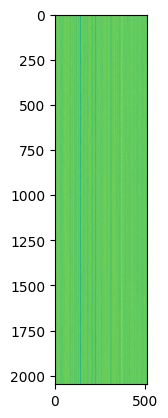

In [ ]:
plt.imshow(embeddings)
plt.show()

One common way of summarising an embedding like this is to compute the **mean embedding** – we can take the mean across the spatial axis and get an embedding of length 512 that represents the entire DNA sequence.

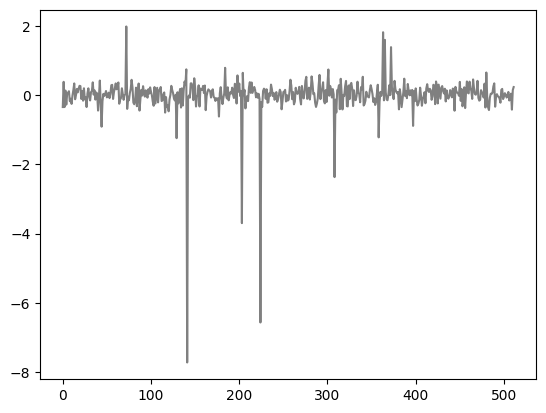

In [ ]:
# Move axis to get broadcasting to work.
attention_mask = np.moveaxis(attention_mask.numpy(), 0, -1)

# Compute mean embedding.
mean_embeddings = np.sum(
    attention_mask * embeddings, axis=0) / np.sum(attention_mask)

plt.plot(mean_embeddings, color='grey')
plt.show()

**It's nice to be able to condense a DNA sequence down to 512 numbers like this, but it's still hard to really know what these numbers mean.**

The value of sequence embeddings really comes out when you **compare them against each other**. So, let's write the function `fetch_random_dna` that will extract some random DNA sequences for a given species:

In [ ]:
def fetch_random_dna(
  organism: str,
  min_length: int,
  max_length: int,
  num_sequences: int,
  max_attempts: int = 50) -> list[str]:
  """Fetch a certain number of DNA sequences of a given length for a species."""
  # Search for nucleotide entries for the organism as we did before.
  handle = Entrez.esearch(
      db='nucleotide', term=f'{organism}[Organism]', retmax=max_attempts)
  record = Entrez.read(handle)
  handle.close()
  if not record['IdList']:
    return []

  # We can collect our DNA sequences in this list.
  sequences = []
  attempts = 0

  while len(sequences) < num_sequences and attempts < max_attempts:
    random_record_id = random.choice(record['IdList'])
    handle = Entrez.efetch(
        db='nucleotide', id=random_record_id, rettype='fasta', retmode='text')
    try:
      seq_record = SeqIO.read(handle, 'fasta')
      handle.close()

      if len(seq_record.seq) >= min_length:
        seq = str(seq_record.seq)
        if len(seq) > max_length:
          seq = seq[:max_length]
        sequences.append(seq)

    # Handle the case where no valid FASTA record was found.
    except ValueError:
      handle.close()
    attempts += 1

  return sequences

Let's use this to fetch one short DNA sequence for human:

In [ ]:
fetch_random_dna(
    organism='Homo sapiens', min_length=10, max_length=50, num_sequences=1)

['TGAGGTACCTCA']

Now we can easily use this to fetch some DNA sequences for the organisms in our list above. The code to do this would look like this:

In [ ]:
NUM_SEQUENCES = 1
MIN_LENGTH = 100
MAX_LENGTH = 1000
random.seed(42)

print(f'Fetching {NUM_SEQUENCES} random DNA sequences of min length '
      f'{MIN_LENGTH} and max length {MAX_LENGTH} for {len(organisms)} '
      'organisms...\n')

dna_sequences = []
organism_labels = []

for organism in tqdm.tqdm(organisms[0:3], desc='Organisms'):
  print(organism, flush=True)
  sequences = fetch_random_dna(
      organism, min_length=MIN_LENGTH, max_length=MAX_LENGTH,
      num_sequences=NUM_SEQUENCES)
  dna_sequences += sequences
  organism_labels += [organism] * len(sequences)

Fetching 1 random DNA sequences of min length 100 and max length 1000 for 10 organisms...



Organisms:   0%|          | 0/3 [00:00<?, ?it/s]

Homo sapiens


Organisms:  33%|███▎      | 1/3 [00:02<00:05,  2.92s/it]

Pan troglodytes


Organisms:  67%|██████▋   | 2/3 [00:04<00:01,  1.85s/it]

Pan paniscus


Organisms: 100%|██████████| 3/3 [00:04<00:00,  1.66s/it]


But this takes a few minutes to run if we wanted say 20 DNA sequences for each of the 10 organisms, so for speed, we pre-fetched some sequences for convenience:

In [ ]:
dna_sequences

,sequence,organism
0,ATCGCTTCTCGGCCTTTTGGCTAAGATCAAGTGTAGTATCTGTTCT...,Homo sapiens
1,ATACTCTGGTTTCTCTTCAGATCGCATAAATCTTTCGCCTTTTACT...,Homo sapiens
2,NGCTTTGCGCAGTGGCAGTATCGTAGCCAATGAGGTCTATCCGAGG...,Homo sapiens
3,ATCAATATCCACCTGCAGATACTACCAAAAGTGTATTTGGAAACTG...,Homo sapiens
4,GGGAGGTTTCCTTGAAGCTTTCGTGCTGACCCTGTCCCTTTTTTTT...,Homo sapiens
...,...,...
195,CGGCGGAGATCTCGAACTACGTCAACATCCAGCGGAAGAAGAAGGT...,Pseudomonas aeruginosa
196,GCTTGCTCATCAGACACCTCTCTCACGGCGAGGATTCTCGCCTAAA...,Pseudomonas aeruginosa
197,ATGAGCGGCGTCGCCCGCGAGGCCATGGAGGACGTCGCGCCGGCGG...,Pseudomonas aeruginosa
198,ATGCTGATCCGCGCCGCAACCTCGACCCTGCTGGTGGTCGATATCC...,Pseudomonas aeruginosa


We can build on our earlier code to extract the mean sequence embeddings of DNA strings:

In [ ]:
def _compute_mean_sequence_embeddings(
  dna_sequences: list[str],
  tokenizer: AutoTokenizer,
  model: AutoModelForMaskedLM):

  max_length = tokenizer.model_max_length
  tokens_ids = tokenizer.batch_encode_plus(
    dna_sequences, return_tensors="pt", padding="max_length",
    max_length=max_length)["input_ids"]

  # Compute the embeddings.
  attention_mask = tokens_ids != tokenizer.pad_token_id

  # Move model and tensors to GPU.
  model = model.to('cuda')
  tokens_ids = tokens_ids.to('cuda')
  attention_mask = attention_mask.to('cuda')

  # By default, PyTorch retains the computation graph for backward pass, but this
  # fills up RAM and we don't need it, so we disable this with torch.no_grad().
  with torch.no_grad():
    torch_outs = model(
      tokens_ids,
      attention_mask=attention_mask,
      encoder_attention_mask=attention_mask,
      output_hidden_states=True,
    )

  # Compute sequences embeddings.
  embeddings = torch_outs['hidden_states'][-1].detach().cpu()

  # Add embed dimension axis.
  attention_mask_cpu = torch.unsqueeze(attention_mask.cpu(), dim=-1)

  # Compute mean embeddings per sequence
  mean_sequence_embeddings = torch.sum(
    attention_mask_cpu * embeddings, axis=-2) / torch.sum(attention_mask_cpu, axis=1)

  return mean_sequence_embeddings.numpy()


def compute_mean_sequence_embeddings(
    dna_sequences: list[str],
    tokenizer: AutoTokenizer,
    model: AutoModelForMaskedLM,
    batch_size: int = 20) -> np.ndarray:
  """Computes mean sequence embeddings for a list of DNA strings."""
  all_mean_embeddings = []

  for i in tqdm.tqdm(range(0, len(dna_sequences), batch_size)):
    batch_sequences = dna_sequences[i:i+batch_size]
    batch_mean_embeddings = _compute_mean_sequence_embeddings(
        batch_sequences, tokenizer, model)
    all_mean_embeddings.extend(batch_mean_embeddings)

  return np.vstack(all_mean_embeddings)


In [ ]:
embeddings = compute_mean_sequence_embeddings(
    dna_sequences['sequence'], tokenizer, language_model)

100%|██████████| 10/10 [00:08<00:00,  1.13it/s]


This gives us an embedding of length 512 for each of the 200 DNA strings:

In [ ]:
embeddings.shape

(200, 512)

It would be great to visualise these. But since humans can't really visualise things in 512-dimensional space, let's first use a dimensionality reduction technique to project the data down to 2 dimensions:

To see if similar types of DNA sequence coming from similar types of species cluster together, we can label each token with either its species label or a more general label like "animal" or "plant", and replot the plot and colour by label:

In [ ]:
%%capture
umap = UMAP(n_components=2, random_state=42)
embeddings_umap = umap.fit_transform(embeddings)

embeddings_umap_df = pd.DataFrame(
    embeddings_umap, columns=['first_dim', 'second_dim'])

embeddings_umap_df['organism'] = dna_sequences['organism']

This gives 2 numbers for each original DNA sequence that still capture some notion of meaning in the DNA:

In [ ]:
embeddings_umap_df

,first_dim,second_dim,organism,label
0,2.346452,7.735291,Homo sapiens,animal
1,0.533603,7.527058,Homo sapiens,animal
2,0.205693,7.170348,Homo sapiens,animal
3,1.070282,7.741261,Homo sapiens,animal
4,0.069148,7.312357,Homo sapiens,animal
...,...,...,...,...
195,3.175597,7.188712,Pseudomonas aeruginosa,bacteria
196,15.273973,7.074193,Pseudomonas aeruginosa,bacteria
197,16.992876,6.275274,Pseudomonas aeruginosa,bacteria
198,16.859295,6.775774,Pseudomonas aeruginosa,bacteria


We can now more easily visualise these, and also color each DNA sequence by the type of organism it comes from:

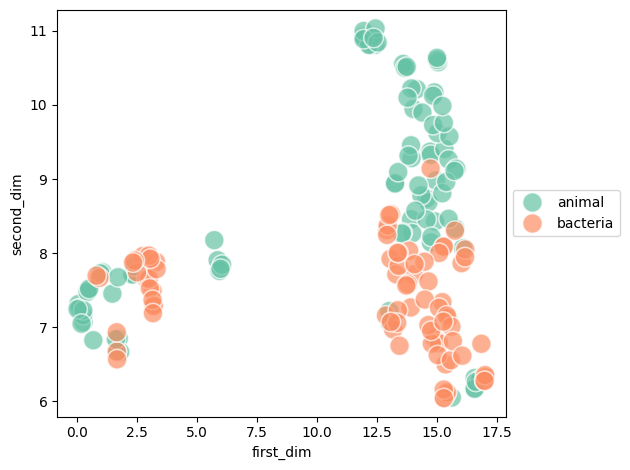

In [ ]:
labels = {
    'Homo sapiens': 'animal',
    'Pan paniscus': 'animal',
    'Pan troglodytes': 'animal',
    'Tursiops truncatus': 'animal',
    'Hydrochoerus hydrochaeris': 'animal',
    'Escherichia coli': 'bacteria',
    'Pseudomonas aeruginosa': 'bacteria',
    'Lactobacillus acidophilus': 'bacteria',
    'Salmonella enterica': 'bacteria',
    }

embeddings_umap_df['label'] = embeddings_umap_df['organism'].map(labels)

ax = sns.scatterplot(data=embeddings_umap_df,
                x='first_dim',
                y='second_dim',
                hue='label', color=None,
                s=200, alpha=0.7, palette='Set2')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()

It appears that while animal vs. bacteria sequences do tend to occupy somewhat different parts of the embedding space, there is certainly a lot of overlap, suggesting that genomes across the tree of life share a lot of similarities.

**Question**: Is this what you expected to see?

In case you're interested in learning more about animal vs. bacterial genomes, here are some fun facts:
- ***Similarities***:
  - **Basic genetic code**: Both animal and bacterial genomes use the same genetic code, with DNA sequences composed of the same four nucleotides: adenine (A), cytosine (C), guanine (G), and thymine (T).
  - **Conserved genes**: Many fundamental genes involved in essential processes, such as DNA replication, transcription, and translation, are conserved across both animals and bacteria.
- ***Differences***:
  - **Genome size**: Animal genomes are typically much larger (humans have 3.2 billion DNA bases) while bacterial genomes are smaller (few hundred thousand to a few million).
  - **Chromosomes**: Animals have multiple linear chromosomes, while bacteria typically have a single circular chromosome.
  - **Gene density**: Bacterial genomes are more gene-dense, while animal genomes are more sparse and have more regulatory elements.
  - **Gene structure**: Animal genes often contain introns (non-coding regions within genes) whereas bacterial genes generally don't.

**Question**: Which of these differences could be captured by the embeddings above?

**Task**:
- Try grabbing some DNA sequences for other species, for example some plant species. Here are a few scientific plant names:
```python
 plants = [
  'Oryza sativa',  # Rice
  'Vitis vinifera',  # Grape
  'Rosa chinensis',  # Rose
  'Musa acuminata',  # Banana
  'Solanum lycopersicum', # Tomato
 ]
 ```
- Try a different dimensionality reduction technique such as tSNE instead of UMAP. Does the scatter plot look different? How sensitive is the scatter plot to changes in the random seed or the other settings?
 - Hint: here is a snippet to get you started with tSNE.

```python
tsne = TSNE(
    n_components=2, learning_rate='auto', init='pca', random_state=0)
embeddings_tsne = tsne.fit_transform(embeddings)
```

## 3. Fine-tuning a DNA language model

In this final section, we will be adapting our DNA language model to a new task by **fine-tuning**.

### What is fine-tuning?
Fine-tuning is the process of taking a **pre-trained model** and making slight adjustments so it can perform a new, specialised task.

Instead of training a model from scratch, which can be very time-consuming and require a lot of data, we start with a model that already understands some general concepts. We then train it further on a smaller, task-specific dataset.

**Pre-training followed up fine-tuning** is a general pattern across machine learning. Here are some examples from natural language and DNA language:


<a href="https://ibb.co/tpd50VH"><img src="https://i.ibb.co/CKrFjRw/ML-for-bio-06.png" alt="NLP vs DNA" border="0" width="400"></a>


### The biological problem

--> **We will be training a model to predict whether a given string of 200 DNA bases will bind a given transcription factor**.

Transcription factors (TFs) are special proteins that bind to DNA and play a crucial role in turning genes on or off.  They are essential because they control the expression of genes, which in turn affects how cells function, develop, and respond to their environment. For example, they can determine whether a cell becomes a muscle cell, a neuron, or a skin cell.

Here is an image of a transcription factor (purple) binding to a certain region of DNA (highlighted in yellow):

<div align="center">
    <img src="https://www.nichd.nih.gov/sites/default/files/2022-05/TranscriptionFactor-400px.jpg" alt="DNA TF binding" width="400">
</div>






Each transcription factor has a certain **binding preference** – it prefers to bind to a specific sequence of DNA bases and not others. This is because the 3D shapes of the TF and the DNA region can fit together well or not.

Humans have over 1,000 transcription factors. We will look at a specific transcription factor called CTCF, which tends to bind to sequences similar to CCACCAGGGGGCGC (with some variation being ok in some positions).

Here is the prediction problem in visual terms:


- For a specific string of 200 DNA base pairs, we want to predict the probability that a given **transcription factor** will bind in that region.


## The dataset

The dataset we will use looks like this:

<a href="https://ibb.co/1ZbY3SF"><img src="https://i.ibb.co/PxtsRSq/ML-for-bio-05.png" alt="dataset description" border="0"></a>

The task is a **binary classification task** – given 200 DNA bases, we predict whether it will bind a specific transcription factor called CTCF. CTCF is actually a particularly interesting transcription factor, because it is involved in **genome architecture**, or the elaborate 3D folding of the genome into specific compartments.

The problem is inspired by one of the eval tasks in this recent [2024 paper preprint](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC10925287/), which sourced the dataset from this [2023 genomics interpretation paper](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC10169356/)

#### Loading the dataset.

The training dataset has already been constructed for you:
- We have 20000 training examples.
- Each one is a mean embedding of the DNA which was extracted using the NT language model.
- The final column of the dataframe is the label, whether the DNA binds the protein CTCF or not

In [ ]:
train_df

,0,1,2,3,4,5,6,7,8,9,...,503,504,505,506,507,508,509,510,511,label
0,-0.218294,0.458433,0.161264,0.039273,0.058276,0.148854,-0.222005,0.349956,-0.022763,-0.036232,...,-0.115031,-0.101608,-0.131688,-0.062489,-0.023282,-0.120040,-0.134666,-0.144946,-0.170490,1
1,-0.067925,0.225154,0.006398,-0.014639,0.142700,0.119179,-0.185538,0.317545,-0.080420,-0.128703,...,-0.101675,-0.024956,0.054387,-0.076459,0.060703,0.041431,-0.081587,0.128414,-0.135343,0
2,-0.036475,0.166806,-0.110220,-0.063861,0.035262,0.140355,-0.094418,0.357013,-0.254630,-0.087556,...,-0.038874,0.002015,0.074428,-0.156386,-0.073927,-0.021240,-0.078350,-0.059282,-0.126573,1
3,-0.038577,0.299374,-0.006287,0.069112,0.007021,-0.056337,-0.193584,0.285849,-0.031823,0.020912,...,-0.109446,-0.023728,-0.050979,-0.138136,0.140089,-0.075259,-0.107878,-0.064560,0.033162,1
4,-0.121926,0.188199,0.037032,0.075284,0.225169,-0.011111,-0.386876,0.291750,-0.004311,-0.066176,...,-0.149256,-0.040005,-0.033149,-0.070501,0.092436,0.054635,-0.070980,-0.016162,-0.089470,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,-0.078043,0.331259,0.131127,0.100249,0.028453,0.080585,-0.193332,0.311815,0.005183,-0.141574,...,-0.010897,-0.206669,-0.012843,-0.087495,-0.024101,0.051706,-0.067643,-0.068765,-0.260701,1
19996,-0.063739,0.334845,-0.036389,0.063847,0.024129,0.151293,-0.068272,0.188731,-0.029114,0.046915,...,-0.296587,-0.047178,-0.010477,-0.169960,-0.010948,-0.090587,-0.108105,-0.122106,0.003401,0
19997,0.034282,0.272324,0.018301,0.014417,0.056953,-0.113989,-0.198752,0.296758,-0.070834,-0.007001,...,-0.085053,-0.109676,0.005655,-0.148586,0.077192,-0.167083,-0.023588,-0.090689,-0.077884,1
19998,-0.250387,0.268849,-0.041865,0.161500,-0.054923,0.036519,-0.095240,0.246107,-0.054131,-0.035582,...,-0.019669,0.026877,-0.000252,-0.186203,-0.046831,-0.017148,-0.175654,-0.072578,0.006978,0


In general, it looks like the 2 classes are fairly balanced (equally represented) in the training dataset, meaning we won't have to do any rebalancing here:

In [ ]:
train_df['label'].value_counts()

,count
label,
0,10081
1,9919


If you are interested, you can have a look at the code for how this dataset was generated, but you do not need to run it here.

#### [You don't need to run this] Dataset creation code.

```python
# 1. Load up the h5 file containing the CTCF datasets.
file_path = os.path.join(ROOT_DIR, 'CTCF_200.h5')

with h5py.File(file_path, 'r') as h5file:
  print("Keys: %s" % list(h5file.keys()))

  # Access each dataset and convert to numpy arrays.
  x_train = h5file['x_train'][()]
  y_train = h5file['y_train'][()]
  x_valid = h5file['x_valid'][()]
  y_valid = h5file['y_valid'][()]
  x_test = h5file['x_test'][()]
  y_test = h5file['y_test'][()]

# Each DNA sequence is one-hot encoded. Visualise the first training example:
fig, ax = plt.subplots(figsize=(12, 12))
plt.imshow(x_train[0, :, :])
plt.show()

# 2. Since our DNA language model actually takes letters as input, we can undo
# the one-hot encoding with a function:

def one_hot_to_dna_batch(one_hot_encoded_batch: np.ndarray):
  """
  Convert a batch of one-hot encoded DNA sequences back to DNA sequence strings.

  Args:
    one_hot_encoded_batch (numpy.ndarray): A 3D numpy array with one-hot encoded
      DNA sequences. Shape should be (num_sequences, sequence_length, 4).

  Returns:
    list: A list of DNA sequences.
  """
  # Define a mapping from one-hot encoding to nucleotides.
  one_hot_mapping = {
      (1, 0, 0, 0): 'A',
      (0, 1, 0, 0): 'C',
      (0, 0, 1, 0): 'G',
      (0, 0, 0, 1): 'T',
  }

  dna_sequences = []

  for one_hot_encoded in one_hot_encoded_batch:
    dna_sequence = []
    for one_hot in one_hot_encoded:
      one_hot_tuple = tuple(one_hot)
      dna_sequence.append(one_hot_mapping[one_hot_tuple])

    dna_sequences.append(''.join(dna_sequence))

  return dna_sequences

NUM_TRAIN_EXAMPLES = 20_000
NUM_VALID_EXAMPLES = 5_000

x_train = one_hot_to_dna_batch(
    np.moveaxis(x_train, 1, -1)[0:NUM_TRAIN_EXAMPLES])
y_train = y_train[0:NUM_TRAIN_EXAMPLES]

x_valid = one_hot_to_dna_batch(
    np.moveaxis(x_valid, 1, -1)[0:NUM_VALID_EXAMPLES])
y_valid = y_valid[0:NUM_VALID_EXAMPLES]

# Peek at training examples and labels:
print(x_train[0:5])
print(y_train[0:5])

# 3. Compute mean DNA language model embeddings of sequences.
train_embeddings = compute_mean_sequence_embeddings(
    x_train, tokenizer, language_model)
train_df = pd.DataFrame(train_embeddings)
train_df['label'] = y_train[:, 0]

valid_embeddings = compute_mean_sequence_embeddings(
    x_valid, tokenizer, language_model)
valid_df = pd.DataFrame(valid_embeddings)
valid_df['label'] = y_valid[:, 0]
```

## Convert the data to a TensorFlow dataset

We will need to convert these dataframes to a TensorFlow dataset that we can easily iterate on while training the model:

In [ ]:
import tensorflow as tf
import numpy as np

def convert_to_tfds(df: pd.DataFrame, batch_size: int=32,
                    is_training: bool=False):
    """Convert embeddings and labels to a TensorFlow dataset."""
    embeddings = np.array(df.iloc[:, :-1])
    labels = np.array(df.iloc[:, -1])[:, None]

    ds = tf.data.Dataset.from_tensor_slices(
        {'embeddings': embeddings, 'labels': labels})

    if is_training:
      ds = ds.shuffle(buffer_size=len(df)).repeat()

    ds = ds.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

    return iter(ds)

BATCH_SIZE = 32

train_ds = convert_to_tfds(
    train_df, batch_size=BATCH_SIZE, is_training=True)
valid_ds = convert_to_tfds(
    valid_df, batch_size=BATCH_SIZE, is_training=False)

Let's take a look at one training batch of data:

In [ ]:
batch = next(train_ds)
batch

{'embeddings': <tf.Tensor: shape=(32, 512), dtype=float64, numpy=
 array([[-0.1114872 ,  0.27980417,  0.02684661, ..., -0.04209897,
         -0.03322605, -0.05715258],
        [ 0.06226031,  0.30887225, -0.04939217, ..., -0.15747367,
         -0.12448421, -0.09733672],
        [-0.1296992 ,  0.20437889,  0.07493491, ..., -0.07063358,
         -0.01555243, -0.10164195],
        ...,
        [-0.2131375 ,  0.3748914 , -0.05705086, ..., -0.11909294,
         -0.07855282, -0.19344343],
        [-0.06665198,  0.40946475,  0.10398961, ..., -0.09309843,
         -0.19692077, -0.15473965],
        [-0.00398321,  0.14622056, -0.09917898, ..., -0.03902043,
         -0.0670076 ,  0.12401944]])>,
 'labels': <tf.Tensor: shape=(32, 1), dtype=int64, numpy=
 array([[1],
        [1],
        [0],
        [0],
        [0],
        [0],
        [1],
        [0],
        [1],
        [0],
        [1],
        [1],
        [0],
        [0],
        [1],
        [0],
        [1],
        [1],
        [1],
 

The dataset is all prepared for model training!

## Fine-tuning the model


We will now train a simple [flax](https://flax.readthedocs.io/en/latest/) linear model on top of the mean DNA embeddings.

Flax is quite similar to many other deep learning frameworks (especially [Haiku](https://dm-haiku.readthedocs.io/en/latest/), if you have encountered it). In our setup, note that our model is only an MLP (multi-layer perceptron, which is multiple linear layers with some non-linearities) – we are not modifying (backpropagating into) the original DNA language model.

In [ ]:
class Model(nn.Module):
  dim: int = 128

  @nn.compact
  def __call__(self, x):
    x = nn.Dense(self.dim * 2)(x)
    x = nn.gelu(x)
    x = nn.Dense(self.dim)(x)
    x = nn.gelu(x)
    x = nn.Dense(1)(x)
    return x

In [ ]:
mlp = Model()

### Training loop

With the model and data set up, we can now initialise our model parameters, our optimiser, and write a function to perform a single training step (which encompasses a model forward pass, a loss computation, a gradient computation, and an update of the model parameters using the gradients):

In [ ]:
LEARNING_RATE = 0.0001

init_rng = jax.random.PRNGKey(42)
variables = mlp.init(init_rng, batch['embeddings'])
params = variables['params']

optimiser = optax.adam(LEARNING_RATE)
opt_state = optimiser.init(params)

You can check out the names of the layers in our neural network like this:

In [ ]:
params.keys()

dict_keys(['Dense_0', 'Dense_1', 'Dense_2'])

And check that the shape of that layer is what you'd expect like this:

In [ ]:
for layer_name in ['Dense_0', 'Dense_1', 'Dense_2']:
  print(params[layer_name]['kernel'].shape)

(512, 256)
(256, 128)
(128, 1)


**Question**: Can you figure out where these shapes come from, given our code in our `class Model` above?

We could already make predictions using these randomly-initiated parameters (it's just that the predictions will be random):

In [ ]:
preds = mlp.apply({'params': params}, batch['embeddings'])
nn.sigmoid(preds)

Array([[0.58091384],
       [0.5803177 ],
       [0.58003753],
       [0.5900895 ],
       [0.5804955 ],
       [0.5903052 ],
       [0.5947331 ],
       [0.58061385],
       [0.59143394],
       [0.58817416],
       [0.5848861 ],
       [0.5839704 ],
       [0.59159577],
       [0.5869089 ],
       [0.5982067 ],
       [0.59783834],
       [0.5788974 ],
       [0.588121  ],
       [0.60000134],
       [0.5741673 ],
       [0.5837109 ],
       [0.5590007 ],
       [0.58644986],
       [0.58409023],
       [0.59882253],
       [0.57772076],
       [0.5818696 ],
       [0.5875549 ],
       [0.57680136],
       [0.58261365],
       [0.5914797 ],
       [0.5821951 ]], dtype=float32)

Let's now define a loss function that we can use to the train these parameters:

In [ ]:
def loss_fn(params, embeddings, labels):
  """Applies sigmoid to logits and computes binary cross-entropy loss."""
  logits = mlp.apply({'params': params}, embeddings)
  loss = optax.sigmoid_binary_cross_entropy(
      logits=logits, labels=labels).mean()
  return loss

Let's compute an example loss:

In [ ]:
embeddings = jnp.array(batch['embeddings'])
labels = jnp.array(batch['labels'])
loss_fn(params, embeddings, labels)

Array(0.67573225, dtype=float32)

So, we expect a loss of around 0.7 for randomly-initialised weights. Hopefully, with model training, we should see losses smaller than this as the model learns the signal in the data! :)

Finally, we can write a training step function:

In [ ]:
@jax.jit
def train_step(params, opt_state, embeddings, labels):
  """A single training step that computes gradients and updates model params."""
  loss, grads = jax.value_and_grad(loss_fn)(params, embeddings, labels)
  updates, opt_state = optimiser.update(grads, opt_state)
  params = optax.apply_updates(params, updates)
  return params, opt_state, loss

### Let's train the model!

In [ ]:
NUM_EPOCHS = 5
NUM_TRAINING_STEPS = (len(train_df) // BATCH_SIZE) * NUM_EPOCHS
LEARNING_RATE = 0.001

# Reinitialise the model to make sure we start fresh each time cell is run.
init_rng = jax.random.PRNGKey(42)
variables = mlp.init(init_rng, batch['embeddings'])
params = variables['params']

optimiser = optax.adam(LEARNING_RATE)
opt_state = optimiser.init(params)

# Keep a record of losses.
running_train_loss = None
running_train_losses = []
valid_losses = []

for epoch in tqdm.tqdm(range(NUM_EPOCHS)):

  # Training loop.
  for step in range(NUM_TRAINING_STEPS):
    batch = next(train_ds)
    embeddings = jnp.array(batch['embeddings'])
    labels = jnp.array(batch['labels'])
    params, opt_state, loss = train_step(params, opt_state, embeddings, labels)

    if running_train_loss is None:
      running_train_loss = loss.item()
    else:
      running_train_loss = 0.99 * running_train_loss + (1 - 0.99) * loss.item()
    running_train_losses.append(running_train_loss)

  # Validation loop.
  valid_ds = convert_to_tfds(valid_df, batch_size=BATCH_SIZE, is_training=False)
  for batch in valid_ds:
    embeddings = jnp.array(batch['embeddings'])
    labels = jnp.array(batch['labels'])
    loss = loss_fn(params, embeddings, labels)
    valid_losses.append(loss.item())

  valid_loss = np.mean(valid_losses)
  print(f'[Epoch {epoch}]: Valid loss={valid_loss:.3f}, '
        f'Train loss={running_train_loss:.3f}\n')

print('Training complete.')

 20%|██        | 1/5 [00:06<00:27,  6.83s/it]

[Epoch 0]: Valid loss=0.600, Train loss=0.564



 40%|████      | 2/5 [00:13<00:20,  6.94s/it]

[Epoch 1]: Valid loss=0.601, Train loss=0.548



 60%|██████    | 3/5 [00:20<00:13,  6.82s/it]

[Epoch 2]: Valid loss=0.586, Train loss=0.529



 80%|████████  | 4/5 [00:27<00:06,  6.83s/it]

[Epoch 3]: Valid loss=0.576, Train loss=0.532



100%|██████████| 5/5 [00:34<00:00,  6.83s/it]

[Epoch 4]: Valid loss=0.571, Train loss=0.523

Training complete.


🎉 🎉 **And we're done with the basic training of the model!** 🎉 🎉

## Sanity-checking the model

We can try inferencing the trained model on any new DNA string of interest. For example, since we know from biological experiments that the CTCF protein binds to DNA sequences containing motifs similar to 'CCACCAGGGGGCGC', then the model should predict a very high probability of binding for DNA containing these motifs.

Let's construct the 200 base long DNA string and grab its embedding:

In [ ]:
ctcf_motif_dna = 'CCACCAGGGGGCGC'*14 + 'AAAA'
print('Length of CTCF motif-filled DNA string:', len(ctcf_motif_dna))

ctcf_motif_embedding = compute_mean_sequence_embeddings(
    [ctcf_motif_dna], tokenizer, language_model)

Length of CTCF motif-filled DNA string: 200


100%|██████████| 1/1 [00:00<00:00, 15.77it/s]


Now we can compute the probability that the DNA will bind CTCF:

In [ ]:
jax.nn.sigmoid(mlp.apply({'params': params}, ctcf_motif_embedding))

Array([[0.9939913]], dtype=float32)

Success! That probability is very close to 1. This means that the model has learned to identify some representation of this motif and associate it with CTCF binding to DNA.

Conversely, random DNA strings should have low probability of binding CTCF:

In [ ]:
%%capture
random_dna_strings = [
    'ACGTACGT'*25,
    'CGGCCGCG'*25,
    'TCGATCGT'*25,
    'TTTTTTTT'*25,
]

probabilities = []

for random_dna_string in random_dna_strings:
  random_dna_embedding = compute_mean_sequence_embeddings(
    [random_dna_string], tokenizer, language_model)

  probabilities.append(
      jax.nn.sigmoid(mlp.apply({'params': params}, random_dna_embedding)))

In [ ]:
probabilities

[Array([[0.00012685]], dtype=float32),
 Array([[0.01015549]], dtype=float32),
 Array([[0.00305125]], dtype=float32),
 Array([[0.02385707]], dtype=float32)]

Great, those all look like close to zero probabilities, which is what we would expect 😎.

## [Optional Follow Ups]

1. **[Plotting Losses]** Try plotting the training loss and validation loss over time. What do you see? Should we train it for longer? Is there overfitting to the training set? If so, how could you improve the situation?
 - **Hint**: try `plt.plot(train_losses, c='grey')`.
2. **[Evaluation Metrics]** So far, we have only been monitoring losses during model training, but these are a bit hard to interpret. How could you implement and track an **accuracy** metric during training?
 - **Hint**: Remember that if you `jax.nn.sigmoid` on the model predictions, it gives the probability that the DNA sequence binds the CTCF protein. You could treat any probability above 0.5 as a prediction of '1', and any probability below 0.5 as a prediction of '0'.
3. **[Hyperparameter Tuning]** Try varying the learning rate, batch size, and number of training steps. How do these changes affect the convergence and final performance of the model?
4. **[Data Augmentation]** Can you think of a way to expand (or augment) the training set? How would you measure if this is helpful for model performance?
5. **[Different Architectures]** Experiment with different model architectures, such as adding more layers or using different activation functions.
 - **Challenge**: if you are feeling very adventurous, try implementing a CNN that can learn directly from (one-hot encoded) DNA sequences!
